# Outlier Detection of 4 Digit MWC 4 Players using Tournament Scores

## Objective

This analysis aims for the main goal of the 4dm4 analysis, which is to find the robust model to **Skillban** the outperformers (Derankers) in rank-restricted tournament with the sample data being **4 digit mwc 4 scores** from official Multiplayer Links. We have defined the **Derankers** as follows

Derankers (n.) *a player who outperforms other players in the rank-restricted tournament.*

"Outperform" is, at a glance, subjective to define. The question arises that what is the criteria of a player to be an *Outperformer* or a *Deranker*. Of course, we use statistics to reduce the "subjectiveness" of the definitions.

## Methodology

Recapped from previous analyses, we have analyzed the follows:
- Dimensionality Reduction Techniques and Various Outlier Detection Models.
    - Note : This attempt failed because how unexplainable the model is
- Regression Analysis to find the Progression of the Scores through the rounds.
- Survival Analysis & Logistic Regression to find the effect of qualifiers scores on the bracket elimination stages.
- Experimentation with Box-Cox Transformation to make our score data Normally Distributed (failed however sadge).

This Notebook is the attempt of applying **Local Outlier Factor (LOF)** to detect the outliers from the model. There will be a twist of Index abusing the **Local Outlier Factor** model using the different distance metric to satisfy our objections.

## Local Outlier Factor

**Local Outlier Factor** is an **Outlier Detection Model** which uses the **Local Reachability Density** to detect the outliers. Namely, the **Data Point** with low Local Density will be considered outliers. Before we go into the details, it would be a good approach to simplify some complicate definitions down.

#### Definitions

**Reachability Distance** : The maximum of distance the point A needs to reach to point B and the distance from point B to their k-closest neighbors. The visualization can be that given B is a friend with k neighbors, how long (or how much distance) would it take to befriend with A.

**Local Reachability Density** : In a nutshell, assuming A has k-nearest neighbors, the Local Reachability Density is how tiring it is for A to communicate with their neighbors face-to-face.

**Local Outlier Factor** : After these two definitions, A compare their extrovertness with neighbors and result in how introvert A is. If A is too introverted (LOF is high) -> A is an outlier.

Well, I hope you guys find this "oversimplification" understandable. However, as Index has mentioned, he abused this introvertness meter with a new distance metric.


### Local Outlier Factor with Elastic Euclidean Distance

Normally, **Local Outlier Factor** model uses **Euclidean Distance** as a main distance metric, namely for defining **Local Reachability Density** and **Local Outlier Factor**. This approach will detect the data points which has less density. This comes with the problem when they detect the point near the center and they don't use "score" as a consideration that much, so we implemented the **Elastic Net** into the Euclidean Distance Metric and call it **Elastic Euclidean Distance**

**Elastic Euclidean Distance** is defined as follows :
```python
def elastic_euclidean(A, B):
    return euclidean(A, B) * lmbda1 + sum(A ** 2) * lmbda2 + sum(abs(A)) * lmbda3
```

where `lmbda1`, `lmbda2` and `lmbda3` are **Hyperparameters** (they are user-defined)

- sum(A ** 2) : is called a "L1 Regularization"
- sum(abs(A)) : is called a "L2 Regularization"

The L2 regularization for our metric tends to detect the players who outperforms other players in a few maps, for example : shokoha has a really good score on specialist, an L2 regularization can detect that

The L1 regularization for our metric tends to detect players who are all-rounded (not really outperformed in the certain maps but in overall, good performances)

However, in this approach, you need to standardize the data (classic (x - mu) / sigma) before fitting the model to prevent the value inflation.

### Local Outlier Factor Code Explanation

In [1]:
import os

os.chdir("..")

#### Import Necessary Libraries

Here, we use `pandas` for DataFrame managements, `matplotlib.pyplot` for further visualization and `numpy` for finding `mean` and `std`

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### Import Necessary Utilities

These are utilities that are available on the original repository. We will use
- **LOF** for Local Outlier Factor Model
- **nan_euclidean** and **elastic_nan_euclidean** for Local Outlier Factor Metric
- **get_table_players** for transforming data which is gathered from `sqlite3 .db`
- **Dataset** to deal with `sqlite3 .db` in general

In [3]:
from utils.lof import LOF
from utils.metrics import nan_euclidean, elastic_nan_euclidean
from utils import get_table_players

In [4]:
from utils import Dataset

#### Defining the Elastic Euclidean Distance

Here, we use `lmbda1` = 1; `lmbda2` = `lmbda3` = 0.25 so the formula of our distance metric is

euclidean(A, B) * 1 + sum(A ** 2) * 0.25 + sum(abs(A)) * 0.25

In [5]:
euclidean_regularized = elastic_nan_euclidean(1, 0.3, 0.1)

#### Initializing the Dataset and Querying the data

We use `4dm4.db` for our current study, and the logit transformation of scores from all round which has the category `LN`, `RC` and `HB`

In [6]:
_4dm4_impute = Dataset('datasets/4dm3.db')

In [7]:
_4dm4_data = _4dm4_impute.select('scores', columns=['player_name', 'round', 'beatmap_type', 'beatmap_tag', 'score_logit'], where={
    'beatmap_type': ['LN', 'RC', 'HB'],
})

#### Data Transformation

We then transform the Queried Data to the table of players and maps

In [8]:
_4dm4_table = get_table_players(_4dm4_data)

#### Standardizing the Data

As mentioned in [this part](#local-outlier-factor-with-elastic-euclidean-distance), we need to standardize data in order to use the model with this metric. So we define `standardized_4dm` then standardize depending on individual maps and ignoring the `NaN` data.

In [9]:
standardized_4dm = pd.DataFrame(index=_4dm4_table.index)

In [10]:
for col in _4dm4_table.columns:
    mu = np.nanmean(_4dm4_table[col]); sigma = np.nanstd(_4dm4_table[col], ddof=1)
    standardized_4dm[col] = _4dm4_table[col].apply(lambda x: (x - mu) / sigma)

In [11]:
standardized_4dm.head()

,Q_RC_1,Q_LN_1,Q_HB_1,GS_RC_1,GS_RC_2,GS_RC_4,GS_LN_1,GS_LN_2,GS_HB_1,RO16_RC_4,...,GF_RC_6,GF_RC_7,GF_LN_1,GF_LN_2,GF_LN_3,GF_HB_2,QF_LN_1,SF_HB_1,GF_HB_3,RO16_HB_2
Scep,2.017505,0.218490,0.713758,2.240486,-1.315069,2.130158,0.531339,0.605757,2.026246,2.219624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chiara,1.127118,0.243935,1.123565,0.612993,2.363380,1.193031,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Paturages,2.371593,NaN,NaN,1.017415,1.030878,1.458316,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2zi,2.227634,NaN,NaN,1.688407,0.869808,0.464348,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZayyKen,1.163159,0.790546,1.877259,2.346803,2.435073,1.507435,1.482213,NaN,2.449809,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Implementing the Local Outlier Factor Model

We then declare the model with n_neighbors (k) = 5 and use our defined Elastic Euclidean Distance as a Metric

In [12]:
lof_euclid = LOF(5, euclidean_regularized)

We then train and predict the Local Outlier Factor of each player, stored in `lof_values`

In [13]:
lof_values = lof_euclid.fit_predict(standardized_4dm.values)

Then we map those in a `DataFrame` in order to assign players their Local Outlier Factors

In [14]:
lof_4dm = pd.DataFrame(index=standardized_4dm.index)

lof_4dm['lof'] = lof_values

This is the outlier score of **shokoha**, an outstanding player in 4 digit MWC 4.

In [15]:
lof_4dm.loc['shokoha']

lof    6.009852
Name: shokoha, dtype: float64

These are top 16 of the players who have the highest outlier scores.

In [16]:
lof_4dm.sort_values(by='lof', ascending=False).head(16)

,lof
Yuragi,27.283062
ZayyKen,12.815177
2fast4you98,11.345807
Scep,11.304370
[-Leon-],10.895436
diamondBIaze,9.197721
-Deepdive-,7.004444
shokoha,6.009852
Lenn,5.747489
palmEuEi,5.692560


Note that there still be an **Underperforming Players** left in this procedure. They will be filtered out in the next study.

We then plot the Distribution and find 1-3th Quartiles and 97.5th Percentile of the Local Outlier Factor

(array([162.,   9.,   3.,   2.,   3.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.32151082,  3.01766599,  5.71382115,  8.40997632, 11.10613148,
        13.80228665, 16.49844181, 19.19459698, 21.89075214, 24.58690731,
        27.28306248]),
 <BarContainer object of 10 artists>)

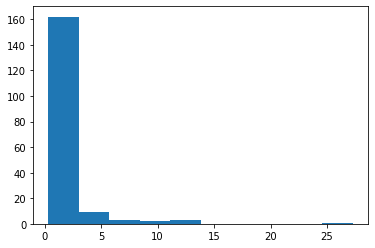

In [17]:
plt.hist(lof_4dm['lof'].values)

In [18]:
print("25% of the LOF is", lof_4dm['lof'].quantile(0.25))
print("Median of the LOF is", lof_4dm['lof'].quantile(0.50))
print("75% of the LOF is", lof_4dm['lof'].quantile(0.75))
print("97.5% of the LOF is", lof_4dm['lof'].quantile(0.975))

25% of the LOF is 0.9143711660917826
Median of the LOF is 1.1298202089537361
75% of the LOF is 1.731045516526231
97.5% of the LOF is 10.089021480611269


### Discussion

As we've discussed, the model is borderline interpretable (There is a way to explain the process of skillbanning and how those numbers come from) to the players. To clarify that the model works, we need the human contribution on handpicking outliers and we can try this model with various tournaments, for example, Violet Mania Tournament organized by Saemitsu.

This model is still undone and lack of ability to visualize however. The left outlier (underperformers) have not been filtered out and we need to work on how to visualize where the outliers are in a few dimensions. This requires dimensionality reduction (to be precise, PCA) and we need to sacrifice some "interpretability" if we demand the images and position of the outliers.

## K-Means Clustering & Principal Component Analysis

From the [discussion](#discussion), our next goal is to filter out the left outliers or players who underperformed in the tournament. We decide to use **K-Means Clustering** to cluster the outliers into two sides and **Principal Component Analysis** to visualize and verify that the clusters that the model yielded is of course the *left outliers* and *right outliers*

### K-Means Clustering

**K-Means Clustering** is the **Unsupervised Clustering Algorithm** based on how close the data point to the given centroids. The algorithm is initialized by generating `k` centroids. Then classify the data points by the nearest centroid. After that move the `n-th` centroid to the center of the data points which are classified to be the type `n`. Do this iteratively until all centroids are stable.

In our analysis, we use **K-Means** to cluster the outliers into two groups, the overperformed ones and underperformed ones. Based on the distinction of these two types of players, this algorithm can be applied with `k=2`.

### Principal Component Analysis

**Principal Component Analysis** is a **Dimensionality Reduction Technique** to generate the similar data points from higher dimensions to lower dimensions. This is the technique used widely in **Exploratory Data Analysis** for high-dimensional data, for example, this dataset is 73-dimensional vectors. We can shrink this down to 2-dimensional plane using the **Eigenvectors of Covariance Matrix** which is called **Principal Components**. However some original features will be lost, but some features still be kept.

### Code Explanation for K-Means Clustering and Principal Component Analysis

#### Importing Necessary Modules

Here we use `sklearn.cluster.KMeans` and `sklearn.decomposition.PCA` to do the following procedures. However `sklearn` machine learning algorithms do not support the `NaN` data, so we need to use `KNN Imputer` from `sklearn.impute` to validate the missing data.

In [19]:
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#### Initializing the Models

We initialize the **KNNImputer** with `n_neighbors = 2`, that means this model will take 2 nearest neighbors as a consideration for missing data, **Kmeans** with `n_clusters = 2` (according to [this](#k-means-clustering)) and **PCA** with 2 Principal Components to perform the data visualization in 2-dimensional plane.

In [20]:
imputer = KNNImputer(n_neighbors=2)
kmeans_twogroups = KMeans(n_clusters=2)
pca_visualization = PCA(n_components=2)

#### Getting Outliers

We define the Outlier Cut-Off, which is the **90th Percentile** according to Local Outlier Factor

In [21]:
outlier_cut = lof_4dm['lof'].quantile(0.90)

We then list the possible outliers

In [22]:
list_possible_outliers = lof_4dm[lof_4dm['lof'] > outlier_cut].index

list_possible_outliers

Index(['Scep', 'Chiara', 'ZayyKen', 'Yuragi', 'KamaTheCrimson', 'diamondBIaze',
       'Lenn', 'Irone OSU', '[-Leon-]', '2fast4you98', 'palmEuEi',
       'NightNarumi', '-Deepdive-', 's_kolorowa', 'Zycrxd', 'shokoha',
       'FastTapper', 'Silicosis'],
      dtype='object')

and the standardized logit scores from those outliers

In [23]:
_4dm_outliers = standardized_4dm.loc[list_possible_outliers]

_4dm_outliers.head()

,Q_RC_1,Q_LN_1,Q_HB_1,GS_RC_1,GS_RC_2,GS_RC_4,GS_LN_1,GS_LN_2,GS_HB_1,RO16_RC_4,...,GF_RC_6,GF_RC_7,GF_LN_1,GF_LN_2,GF_LN_3,GF_HB_2,QF_LN_1,SF_HB_1,GF_HB_3,RO16_HB_2
Scep,2.017505,0.218490,0.713758,2.240486,-1.315069,2.130158,0.531339,0.605757,2.026246,2.219624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chiara,1.127118,0.243935,1.123565,0.612993,2.363380,1.193031,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZayyKen,1.163159,0.790546,1.877259,2.346803,2.435073,1.507435,1.482213,NaN,2.449809,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yuragi,1.152799,-9.537727,1.173316,-0.844329,1.424556,1.894604,1.685593,NaN,-0.404182,NaN,...,-1.640051,1.370147,0.249612,-0.188456,1.292057,0.343507,NaN,NaN,NaN,NaN
KamaTheCrimson,2.069388,0.709926,0.924570,1.552468,1.303097,1.055632,1.651545,0.052200,2.321897,0.307987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Validating the Missing Data

We then use our **KNN Imputer** to validate the missing scores from all players and outliers

In [24]:
imputed_players = imputer.fit_transform(standardized_4dm)

imputed_outliers = imputer.transform(_4dm_outliers)

#### Principal Component Analysis Visualization

We train our PCA Model with players data and transform the outlier data into two dimensional data, after that we plot them in the 2d plane.

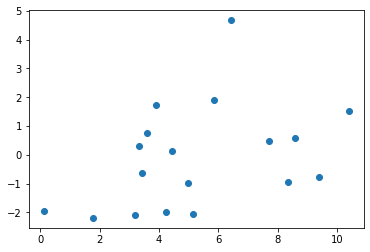

In [25]:
# For visualization purposes

pca_visualization.fit(imputed_players)

pca_outliers = pca_visualization.transform(imputed_outliers)

plt.scatter(*pca_outliers.T)

#### Principal Component Analysis Visualization with K-Means Clustering

We then perform the training procedure of our K-Means Clustering Models, then getting both centroids using the attribute `.cluster_centers_`. After that we transform the centroids into 2-dimensional points using our PCA Model. Then visualize the outliers and K-means Centroid using Scatter Plot.

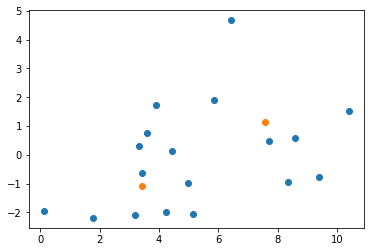

In [26]:
kmeans_twogroups.fit(imputed_outliers)

centroids = kmeans_twogroups.cluster_centers_

pca_kmeans = pca_visualization.transform(centroids)

plt.scatter(*pca_outliers.T)
plt.scatter(*pca_kmeans.T)

We can see that our K-means model did a really good job on distinguishing between two types of outliers. Next, we will obtain the *right outliers* or *Derankers* from the model.

#### Predicting the Outliers (Skillbanning)

We then use the outlier score data that has been done the Missing Data Validation, after that we find the *right outliers* side by getting the prediction result of the extreme case (in this case, `10 * standard deviation` ahead of the average scores). After we get the correct class for the *right outliers*, we then filter the data points which are in the same class with the *right outliers* class.

In [27]:
kmean_prediction = kmeans_twogroups.predict(imputed_outliers)

right_ol_side = int(kmeans_twogroups.predict(np.ones((1, imputed_outliers.shape[1])) * 10))

right_outliers = list_possible_outliers[kmean_prediction == right_ol_side]

right_outliers


Index(['Scep', 'Chiara', 'ZayyKen', 'Yuragi', 'diamondBIaze', 'Lenn',
       '[-Leon-]', '2fast4you98'],
      dtype='object')

We get the **Local Outlier Factor** scores from those *right outliers*.

In [28]:
lof_4dm.loc[right_outliers].sort_values(by='lof', ascending=False)

,lof
Yuragi,27.283062
ZayyKen,12.815177
2fast4you98,11.345807
Scep,11.304370
[-Leon-],10.895436
diamondBIaze,9.197721
Lenn,5.747489
Chiara,3.208071


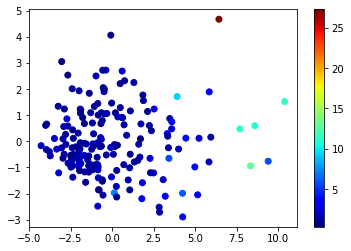

In [29]:
_2d_vis = pca_visualization.transform(imputed_players)

plt.scatter(*_2d_vis.T, c=lof_4dm.values, cmap='jet')
plt.colorbar()
plt.show()

[0.27294393 0.06085731 0.05660576]


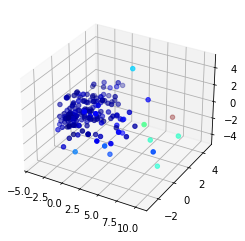

In [30]:
pca_3d = PCA(n_components=3)

_3d_vis = pca_3d.fit_transform(imputed_players)
print(pca_3d.explained_variance_ratio_)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(*_3d_vis.T, c=lof_4dm.values, cmap='jet')
plt.show()